<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220808.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg 
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta 

import os 
import re

from functools import reduce 
from collections import ChainMap, defaultdict, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 'sales_train.csv',
 'listings.csv',
 'ecommerce-data.csv',
 'shops.csv',
 'rfm_test.csv',
 'retail_data_transactions.csv',
 'items.csv',
 '.Rhistory',
 'item_categories.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'retail_data_response.csv',
 'online_retail_II.xlsx',
 'sample_submission.csv',
 'test.csv',
 'sample_data']

In [4]:
df = pd.read_csv('retail_data_transactions.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [5]:
df['date'] = pd.to_datetime(df.trans_date)
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df = df[['customer_id', 'date', 'month', 'tran_amount']].rename(columns = {'customer_id':'id', 'tran_amount':'rev'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,CS1112,2011-06-15,2011-06-01,56
1,CS1112,2011-08-19,2011-08-01,96
2,CS1112,2011-10-02,2011-10-01,60
3,CS1112,2012-04-08,2012-04-01,56
4,CS1112,2012-06-24,2012-06-01,52


In [6]:
list_pu = df.groupby(['id','month'])['rev'].sum().reset_index().sort_values(['id','month'], ascending = [1,1])
list_npu = list_pu.groupby(['id']).first().reset_index()
list_mon = list_npu['month'].sort_values().unique()

In [8]:
for mon in list_mon : 
  temp_npu = list_npu[list_npu['month'] == mon]
  temp_pu = list_pu[list_pu['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['month'])['id'].count().reset_index().rename(columns = {'id':'pu'})
  temp = temp.assign(npu_month = str(mon)[:10],
                     num = temp['month'].rank(),
                     ratio = lambda x : round(x['pu']/x['pu'].max() * 100, 2)
                     )
  
  temp = temp[['npu_month', 'num', 'pu', 'ratio']]

  if mon == list_mon[0] :

    res = temp

  else : 

    res = pd.concat([res, temp], axis = 0)

res = pd.melt(res, id_vars = ['npu_month', 'num'], var_name = 'type')
res.head()

,npu_month,num,type,value
0,2011-05-01,1.0,pu,1344.0
1,2011-05-01,2.0,pu,426.0
2,2011-05-01,3.0,pu,460.0
3,2011-05-01,4.0,pu,491.0
4,2011-05-01,5.0,pu,448.0


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


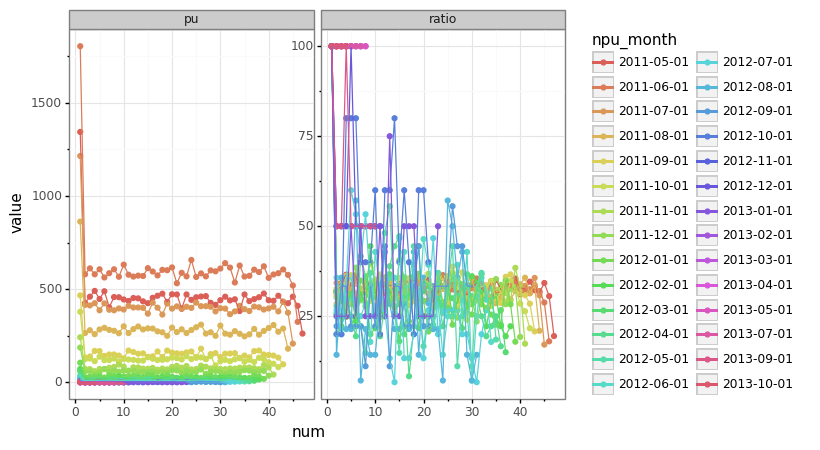

<ggplot: (8733914951257)>

In [9]:
(
    ggplot(res, aes('num', 'value', color = 'npu_month')) +
    gg.geom_point() +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

In [12]:
info_m = df.groupby(['id','month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').reset_index().sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,CS1112,39.0
1,CS1113,220.0
2,CS1114,79.0
3,CS1115,55.0
4,CS1116,0.0


In [13]:
info_f = df.groupby(['id','month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').reset_index().sort_values(['id','month'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,CS1112,1.0
1,CS1113,2.0
2,CS1114,1.0
3,CS1115,1.0
4,CS1116,0.0


In [14]:
date_max = (df['date'] + pd.offsets.MonthEnd(0)).max()
date_max

Timestamp('2015-03-31 00:00:00')

In [20]:
info_r = df.groupby(['id']).agg({'date' : lambda x : (date_max - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,recency
0,CS1112,76
1,CS1113,50
2,CS1114,47
3,CS1115,26
4,CS1116,218


In [21]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id').reset_index()
info = info.assign(r = pd.qcut(info.recency, 5, list('54321')),
                   f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')),
                   m = pd.qcut(info.money.rank(method = 'first'), 5, list('12345'))
                   )
info['fm'] = info.f.astype(str) + info.m.astype(str)
info.head()

,index,id,recency,freq,money,r,f,m,fm
0,0,CS1112,76,1.0,39.0,3,2,3,23
1,1,CS1113,50,2.0,220.0,4,4,5,45
2,2,CS1114,47,1.0,79.0,4,2,4,24
3,3,CS1115,26,1.0,55.0,5,2,3,23
4,4,CS1116,218,0.0,0.0,1,1,1,11


# iterator

In [22]:
mat = [list('ABC'), list('DEF'), list('GHI')]

for r, rows in enumerate(mat) :
  for c, letter in enumerate(rows) :
    print(f'({r},{c})-{letter}')

(0,0)-A
(0,1)-B
(0,2)-C
(1,0)-D
(1,1)-E
(1,2)-F
(2,0)-G
(2,1)-H
(2,2)-I


In [23]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'age': 73,
  'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M'},
 {'age': 29,
  'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F'},
 {'age': 51,
  'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M'},
 {'age': 32,
  'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F'},
 {'age': 42, 'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F'}]

In [24]:
for key in list(users[0].keys()) :
  if key == list(users[0].keys())[0] :

    res = eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')

  else : 

    res = np.c_[res, eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')]

res

array([['gregorythomas@gmail.com', 'Brett Holland', 'M', '73'],
       ['hintoncynthia@hotmail.com', 'Madison Martinez', 'F', '29'],
       ['wwagner@gmail.com', 'Michael Jenkins', 'M', '51'],
       ['daniel79@gmail.com', 'Karen Rodriguez', 'F', '32'],
       ['ujackson@gmail.com', 'Amber Rhodes', 'F', '42']], dtype='<U25')

In [25]:
portfolio = [
    ('GOOG', 100, 490.1),
    ('IBM', 50, 91.1),
    ('CAT', 150, 83.44),
    ('IBM', 100, 45.23),
    ('GOOG', 75, 572.45),
    ('AA', 50, 23.15)
]
portfolio

[('GOOG', 100, 490.1),
 ('IBM', 50, 91.1),
 ('CAT', 150, 83.44),
 ('IBM', 100, 45.23),
 ('GOOG', 75, 572.45),
 ('AA', 50, 23.15)]

In [27]:
a, b, c, d = Counter(), defaultdict(int), defaultdict(int), defaultdict(list)

for com, share, price in portfolio :
  a[com] += 1 
  b[com] += 1
  c[com] += share
  d[com].append((share, price))
  
print(a)
print(b)
print(c)
print(d)

Counter({'GOOG': 2, 'IBM': 2, 'CAT': 1, 'AA': 1})
defaultdict(<class 'int'>, {'GOOG': 2, 'IBM': 2, 'CAT': 1, 'AA': 1})
defaultdict(<class 'int'>, {'GOOG': 175, 'IBM': 150, 'CAT': 150, 'AA': 50})
defaultdict(<class 'list'>, {'GOOG': [(100, 490.1), (75, 572.45)], 'IBM': [(50, 91.1), (100, 45.23)], 'CAT': [(150, 83.44)], 'AA': [(50, 23.15)]})
